# Data and libraries import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Import the CSV file containing the DeepLearWing dataset.
# We assume the data file is named 'DeepLearWing.csv' and is in the same directory.
try:
    df = pd.read_csv('DeepLearWing.csv')
    print("Data file loaded successfully.")
except FileNotFoundError:
    print("Error: 'DeepLearWing.csv' not found.")
    print("Please make sure the file is in the correct directory and with proper name.")
    sys.exit()

Data file loaded successfully.


# Outputing 3 random airfoils and their data

C:\Users\skrze\AppData\Local\Temp\ipykernel_19404\508755580.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_plot.legend()


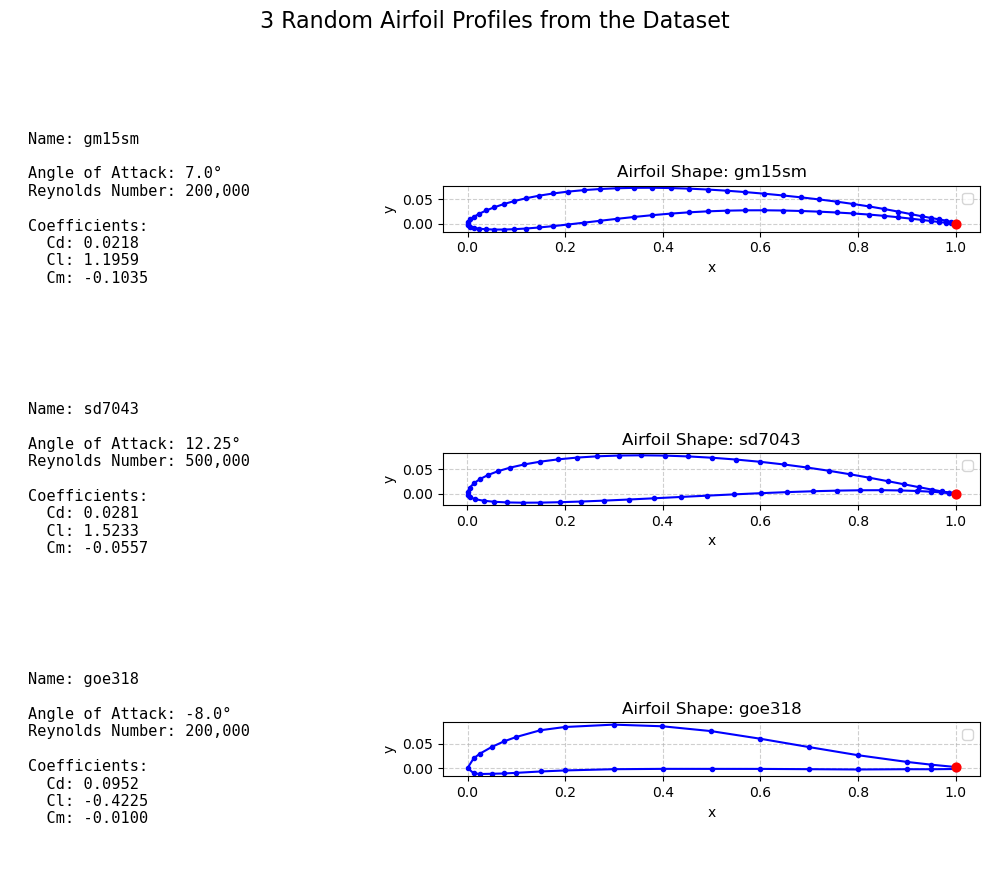

In [3]:
# Select 3 random entries from the airfoil database to show the data.
# sample(n=3) draws 3 random rows.
random_airfoils = df.sample(n=3)

# Helper function to parse coordinate strings.
def parse_coords(coord_string):
    """Converts a space-separated string of coordinates into a list of floats."""
    if isinstance(coord_string, str):
        return [float(c) for c in coord_string.strip().split()]
    return []


# We create a figure with 3 rows and 2 columns to visualise the database using Matplotlib..
# gridspec_kw allows setting different widths for the columns.
fig, axes = plt.subplots(3, 2, figsize=(10, 9), 
                         gridspec_kw={'width_ratios': [1, 1.5]})

fig.suptitle('3 Random Airfoil Profiles from the Dataset', fontsize=16)

# Iterate through the sampled airfoils and plot axes.
for i, (index, row) in enumerate(random_airfoils.iterrows()):
    ax_text = axes[i, 0]
    ax_text.axis('off') # Turn off the axis for the text cell.

    # Collect data for display.
    name = row['name']
    angle = row['angle']
    reynolds = row['reynolds']
    cd = row['cd']
    cl = row['cl']
    cm = row['cm']
    
    info_text = (
        f"Name: {name}\n\n"
        f"Angle of Attack: {angle}°\n"
        f"Reynolds Number: {reynolds:,.0f}\n\n"
        f"Coefficients:\n"
        f"  Cd: {cd:.4f}\n"
        f"  Cl: {cl:.4f}\n"
        f"  Cm: {cm:.4f}"
    )
    
    # Display the text about the airfoil in the cell.
    ax_text.text(0.05, 0.5, info_text, transform=ax_text.transAxes,
                 fontsize=11, verticalalignment='center', family='monospace')

    ax_plot = axes[i, 1]

    x_coords = parse_coords(row['x_coords'])
    y_coords = parse_coords(row['y_coords'])
    
    # Ploting the airfoil shape.
    ax_plot.plot(x_coords, y_coords, marker='o', markersize=3, linestyle='-', color='b')
    ax_plot.scatter([x_coords[0]], [y_coords[0]], color='red', s=40, zorder=5,) # Highlight the start point.
    
    # Configuring the plot settings.
    ax_plot.set_title(f'Airfoil Shape: {name}')
    ax_plot.set_xlabel('x')
    ax_plot.set_ylabel('y')
    ax_plot.grid(True, linestyle='--', alpha=0.6)
    ax_plot.set_aspect('equal', adjustable='box')
    ax_plot.legend()

# Adjusting the layout, rect leaves space for the main title.
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Data Preprocessing for the CNN Model

In [ ]:
def parse_coords(coord_string):
    """Converts a space-separated string of coordinates into a list of floats."""
    if isinstance(coord_string, str):
        return [float(c) for c in coord_string.strip().split()]
    return []

# function to convert airfoil coordinates to a rasterized image
IMAGE_SIZE = 64
def rasterize_airfoil(points, image_size=IMAGE_SIZE):
    """Converts a sequence of points into a binary image."""
    if not points:
        return np.zeros((image_size, image_size), dtype=np.float32)

    image = np.zeros((image_size, image_size), dtype=np.float32)
    points = np.array(points)

    # Normalize points to fit within the image boundaries with some padding
    points[:, 0] -= points[:, 0].min() # Normalize x
    points[:, 1] -= points[:, 1].min() # Normalize y
    
    # Scale to fit image size with a 10% padding
    scale_factor = 0.8 * image_size / max(points[:, 0].max(), points[:, 1].max(), 1e-6)
    points *= scale_factor
    
    # Center the airfoil
    offset_x = (image_size - points[:, 0].max()) / 2
    offset_y = (image_size - points[:, 1].max()) / 2
    points[:, 0] += offset_x
    points[:, 1] += offset_y
    
    points = points.astype(int)

    # Drawing lines between consecutive points
    for i in range(len(points) - 1):
        x1, y1 = points[i]
        x2, y2 = points[i+1]
        
        # Simple line drawing
        dx = abs(x2 - x1)
        dy = -abs(y2 - y1)
        sx = 1 if x1 < x2 else -1
        sy = 1 if y1 < y2 else -1
        err = dx + dy
        
        while True:
            if 0 <= x1 < image_size and 0 <= y1 < image_size:
                image[y1, x1] = 1.0
            if x1 == x2 and y1 == y2:
                break
            e2 = 2 * err
            if e2 >= dy:
                err += dy
                x1 += sx
            if e2 <= dx:
                err += dx
                y1 += sy
    
    return image

print("\n Starting Data Preprocessing for CNN Model ")

# Parse coordinates and create point sequences first
df['x_coords_list'] = df['x_coords'].apply(parse_coords)
df['y_coords_list'] = df['y_coords'].apply(parse_coords)
df['points'] = [list(zip(x, y)) for x, y in zip(df['x_coords_list'], df['y_coords_list'])]

# Create rasterized images from point sequences
df['image'] = df['points'].apply(rasterize_airfoil)


features_scalar = ['angle', 'reynolds']
features_image = 'image' 
targets = ['cl', 'cd', 'cm']

# Data splitting 
airfoil_names = df['name'].unique()
train_names, test_names = train_test_split(airfoil_names, test_size=0.1, random_state=42)
val_names, test_names = train_test_split(test_names, test_size=0.1, random_state=42)

train_df = df[df['name'].isin(train_names)]
val_df = df[df['name'].isin(val_names)]
test_df = df[df['name'].isin(test_names)]

print(f"Data split into: \n- Train: {len(train_df)} samples\n- Validation: {len(val_df)} samples\n- Test: {len(test_df)} samples")

# Normalization
scalar_feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
train_df[features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
train_df[targets] = target_scaler.fit_transform(train_df[targets])
val_df[features_scalar] = scalar_feature_scaler.transform(val_df[features_scalar])
val_df[targets] = target_scaler.transform(val_df[targets])
test_df[features_scalar] = scalar_feature_scaler.transform(test_df[features_scalar])
test_df[targets] = target_scaler.transform(test_df[targets])

print("Scalar features and targets have been normalized.")



 Starting Data Preprocessing for CNN Model 
Data split into: 
- Train: 736801 samples
- Validation: 73574 samples
- Test: 8816 samples
Scalar features and targets have been normalized.


C:\Users\skrze\AppData\Local\Temp\ipykernel_19404\2924811168.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
C:\Users\skrze\AppData\Local\Temp\ipykernel_19404\2924811168.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[targets] = target_scaler.fit_transform(train_df[targets])
C:\Users\skrze\AppData\Local\Temp\ipykernel_19404\2924811168.py:91: SettingWithCopyWarning: 
A value is trying to be set on a 

# PyTorch Dataset and DataLoader for CNN

In [6]:
class AirfoilDatasetCNN(Dataset):
    """Custom PyTorch Dataset for airfoil data, modified for CNN."""
    def __init__(self, dataframe):
        self.dataframe = dataframe.reset_index(drop=True)
        # Images need an extra channel dimension for Conv2d: (N, C, H, W)
        self.images = torch.tensor(np.stack(self.dataframe[features_image].values), dtype=torch.float32).unsqueeze(1)
        self.other_features = torch.tensor(self.dataframe[features_scalar].values, dtype=torch.float32)
        self.targets = torch.tensor(self.dataframe[targets].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        original_data_row = self.dataframe.iloc[idx]
        return self.images[idx], self.other_features[idx], self.targets[idx], original_data_row

# The default collate_fn is sufficient now, but we keep a simple one for clarity.
def collate_fn_cnn(batch):
    images, other_features, targets, original_data = zip(*batch)
    return torch.stack(images), torch.stack(other_features), torch.stack(targets), list(original_data)

# Create Datasets
train_dataset = AirfoilDatasetCNN(train_df)
val_dataset = AirfoilDatasetCNN(val_df)
test_dataset = AirfoilDatasetCNN(test_df)

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("PyTorch Datasets and DataLoaders for CNN created.")

MemoryError: Unable to allocate 11.2 GiB for an array with shape (736801, 64, 64) and data type float32

# CNN model

# Model training

# Saving model

In [ ]:
torch.save(model, 'saved_model_cnn.pth')

# Evaluating model on 10 random airfoils

# Showing training and validation loss based on CNN model

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()